#### Time series forecasting in Python (for noobs)

Time series data is basically f(t) where t = time. Given f(t), t = 0, 1, ...n, we want to predict the future. To do forecasting, we need the time series to be stationary process. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('https://raw.githubusercontent.com/aliasvishnu/ARIMA-Forecasting-Intro/master/AirPassengers.csv',  index_col='Month',  parse_dates = ['Month'], date_parser = dateparse)
ts = data["#Passengers"] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

Checking the stationarity

Assume we have time series data, for eg. stock prices (I'm highly innovative, i know) . 
What is stationary process?
* Mean = constant over all intervals.
* Variance = constant over all intervals.

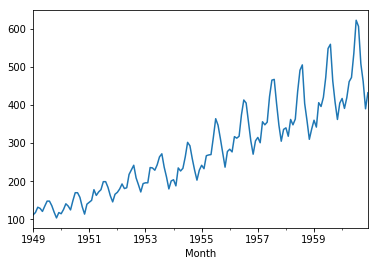

In [5]:
ts.plot()

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* Constant mean
* Constant variance
* An autocovariance that does not depend on time.

<b>Plotting Rolling Statistics:</b> We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

<b>Dickey-Fuller Test:</b> This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ```Test Statistic``` is less than the ```Critical Value```, we can reject the null hypothesis and say that the series is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


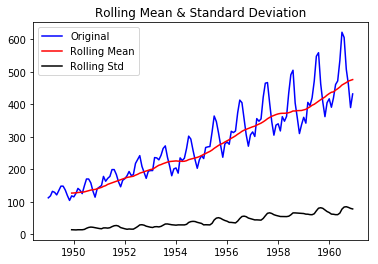

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
test_stationarity(ts)

Therefore, the time series is not stationary.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.


To eliminate **trend** we will apply a transformation that makes the values more or less same, ie. we use log

#### One way to eliminate trend (that doesn't always work)

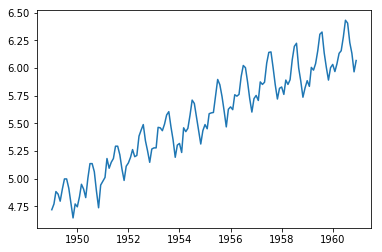

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

We will deal with the noise by taking rolling mean i.e. smoothing

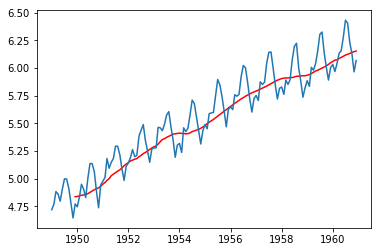

In [12]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

In [13]:
# Case 1: No subtraction
no_sub_ts = ts_smooth
no_sub_ts.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)

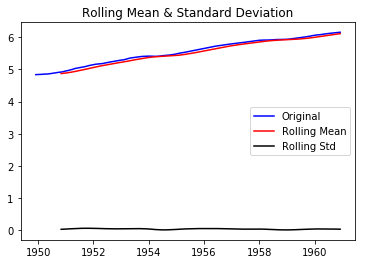

Results of Dickey-Fuller Test:
Test Statistic                  -1.737158
p-value                          0.412076
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


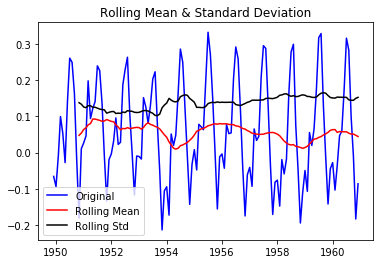

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [14]:
# Perform Dickey-Fuller on both
test_stationarity(no_sub_ts)
test_stationarity(sub_ts)

Exponential weighted average instead of rolling average

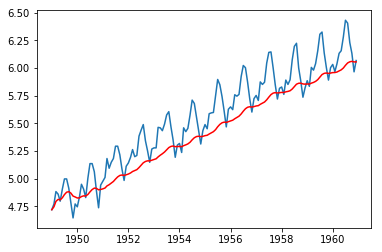

In [15]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

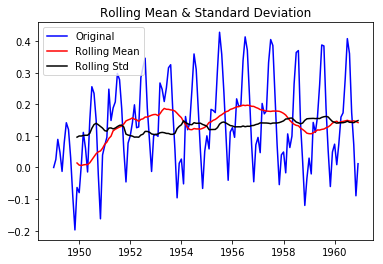

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
exp_ts_diff = ts_log-expwighted_avg
test_stationarity(exp_ts_diff)

Since test statistic is lower than 1% critical value, it means that we are 99% sure that we have a stationary series.

Other ways of eliminating trend and seasonality,
* Differencing
* Decomposition

**Differencing**

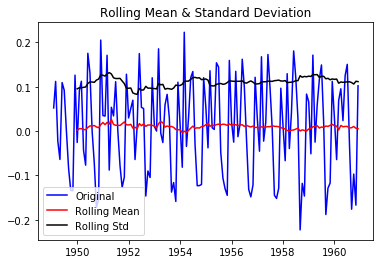

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [17]:
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

How about differencing + exponential weighting?

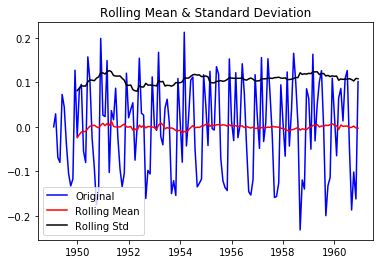

Results of Dickey-Fuller Test:
Test Statistic                  -4.067811
p-value                          0.001094
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [18]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

Great! We got confidence of 99%. 

** Decomposition **

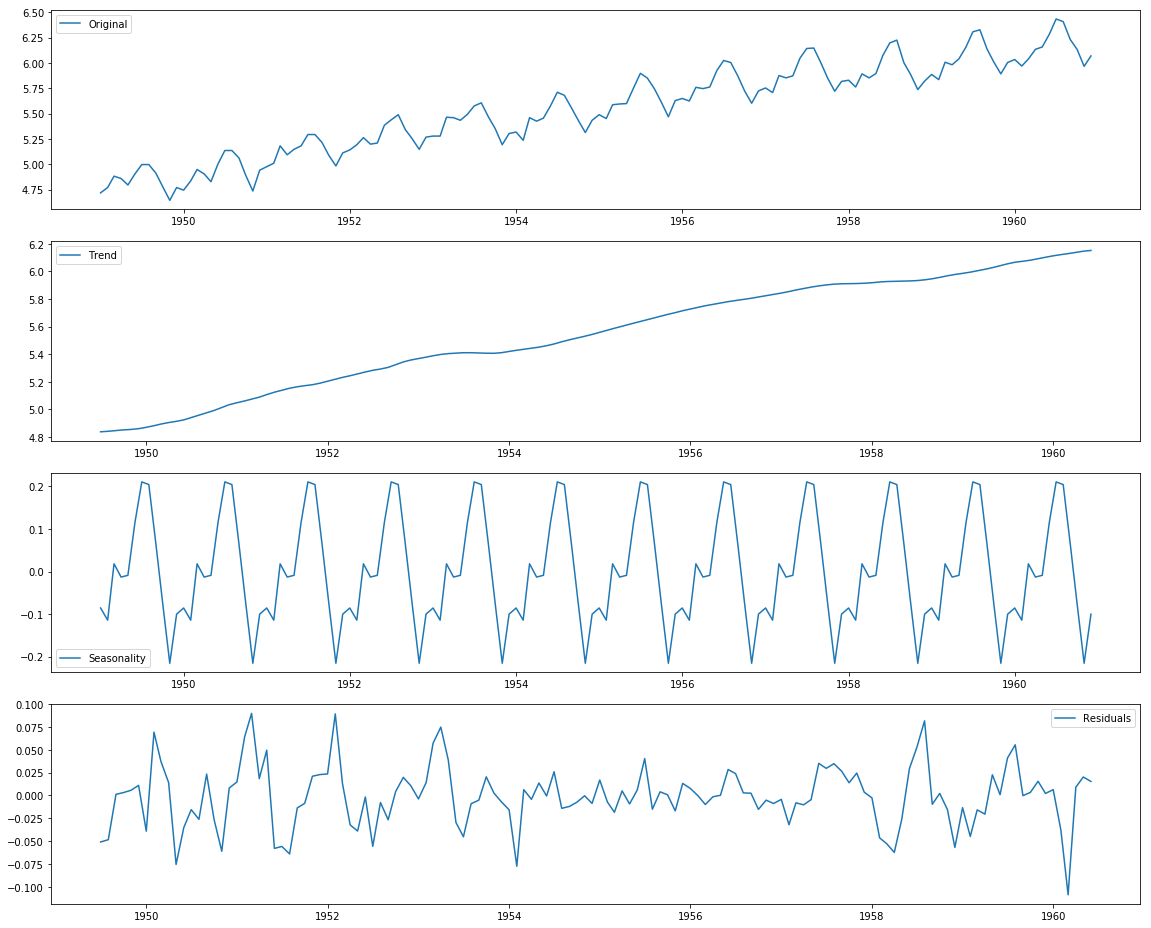

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,13))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

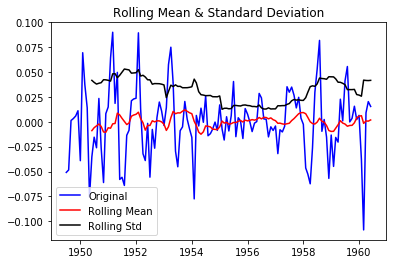

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (5%)           -2.885538e+00
Critical Value (1%)           -3.485122e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [101]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

### Forecasting

Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.



**Selecting p, q, and d values**
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


In [103]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [105]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

Text(0.5,1,u'Partial Autocorrelation Function')

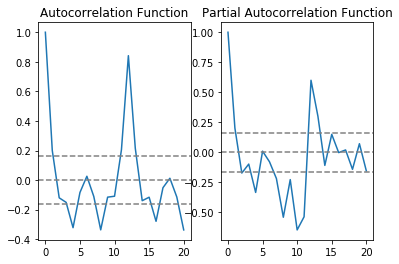

In [108]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

p = 2, q = 2

Now AR, MA & ARIMA models for the data

In [109]:
from statsmodels.tsa.arima_model import ARIMA

AR model

Text(0.5,1,u'RSS: 1.5023')

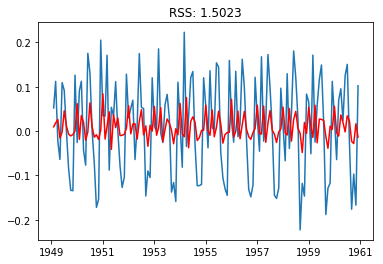

In [111]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

Text(0.5,1,u'RSS: 1.4721')

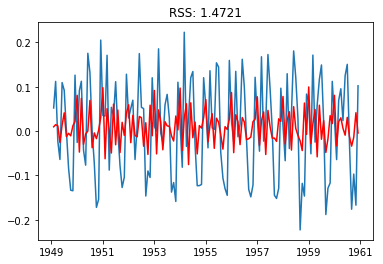

In [114]:
# MA model

model = ARIMA(ts_log, order=(0, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

/Users/sriramravindran/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,u'RSS: 1.0292')

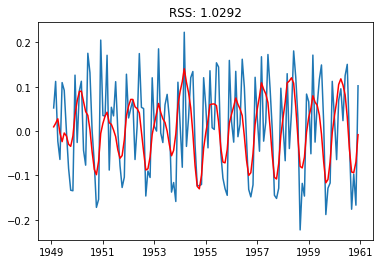

In [115]:
# ARIMA model

model = ARIMA(ts_log, order=(2, 1, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [120]:
preds = pd.Series(results_AR.fittedvalues, copy = True)
preds_cumsum = preds.cumsum()
print preds_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [125]:
preds_log = pd.Series(ts_log.ix[0], index=ts_log.index)
preds_log = preds_log.add(preds_cumsum,fill_value=0)
preds_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5,1,u'RMSE: 90.1046')

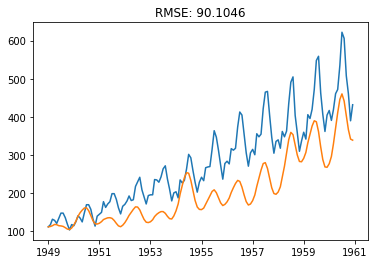

In [127]:
preds_ARIMA = np.exp(preds_log)
plt.plot(ts)
plt.plot(preds_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((preds_ARIMA-ts)**2)/len(ts)))